In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## 1. Загрузите данные ex2data1.txt из текстового файла.

In [2]:
df = pd.read_csv('data/ex2data1.txt', header=None, names=['first_exam', 'second_exam', 'accepted'])
x_train, y_train = df.filter(['first_exam', 'second_exam']), df['accepted']
df

,first_exam,second_exam,accepted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1
...,...,...,...
95,83.489163,48.380286,1
96,42.261701,87.103851,1
97,99.315009,68.775409,1
98,55.340018,64.931938,1


## 2. Постройте график, где по осям откладываются оценки по предметам, а точки обозначаются двумя разными маркерами в зависимости от того, поступил ли данный студент в университет или нет.

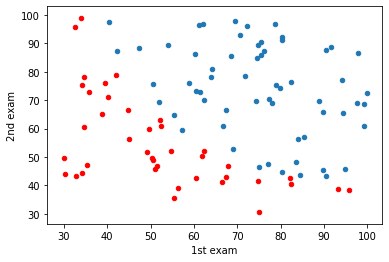

In [3]:
df_accepted = df[df['accepted'] == 1]
df_not_accepted = df[df['accepted'] == 0]
fig, ax = plt.subplots()
ax.scatter(df_accepted['first_exam'], df_accepted['second_exam'], marker='o', label='Accepted', s=20)
ax.scatter(df_not_accepted['first_exam'], df_not_accepted['second_exam'], marker='o', c='r', label='Not accepted', s=20)
ax.set_xlabel('1st exam')
ax.set_ylabel('2nd exam')
plt.show()

## 3. Реализуйте функции потерь J(θ) и градиентного спуска для логистической регрессии с использованием векторизации.

In [99]:
# https://www.youtube.com/watch?v=HIQlmHxI6-0&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=36&t=0s
# https://www.youtube.com/watch?v=TTdcc21Ko9A&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=37&t=0s

THRESHOLD = 1e-8

def sigmoid(z):
    return 1 / (1 + np.e ** (-z))

def h(x, theta):
    return sigmoid(x.dot(theta))
    
def cost_func_vectorized(x, y, theta, **kwargs):
    h_theta = h(x, theta)
    cost_1 = y * np.log(h_theta)
    cost_0 = (1 - y) * np.log(1 - h_theta)
    return -np.mean(cost_1 + cost_0)

def cost_func_deriative(x, y, theta, **kwargs):
    h_v = h(x, theta)
    gradient = np.dot(x.T, h(x, theta) - y)
    gradient /= x.shape[0]
    return gradient

def gradient_descent_vectorized(x, y, theta, a=1, max_iter_count=30000,
                                cost_func=cost_func_vectorized, cost_func_der=cost_func_deriative,
                                **kwargs):
    logs = []
    last_loss = cost_func(x, y, theta)
    for iter_num in range(max_iter_count):
        gradient = cost_func_der(x, y, theta, **kwargs)
        theta -= gradient * a
        curr_loss = cost_func(x, y, theta, **kwargs)

        logs.append([iter_num, curr_loss])

        if abs(curr_loss - last_loss) < THRESHOLD:
            break

        last_loss = curr_loss

    return theta, logs

In [5]:
def fit(x_train, y_train, minimization_func=gradient_descent_vectorized, regularized=False,
        cost_func=cost_func_vectorized, cost_func_der=cost_func_deriative, **kwargs):

    x = getattr(x_train, 'values', x_train).astype('float64')
    y = getattr(y_train, 'values', y_train).astype('float64')

    if not regularized:
        x = np.column_stack((np.ones(x.shape[0]), x))

    theta = np.zeros(x.shape[1])
    return minimization_func(x, y, theta, cost_func=cost_func,
                             cost_func_der=cost_func_der, **kwargs)

## 4. Реализуйте другие методы (как минимум 2) оптимизации для реализованной функции стоимости (например, Метод Нелдера — Мида, Алгоритм Бройдена — Флетчера — Гольдфарба — Шанно, генетические методы и т.п.). Разрешается использовать библиотечные реализации методов оптимизации (например, из библиотеки scipy).

In [6]:
# Nelder-Mead method
def nelder_mead_algo(x, y, theta, cost_func=cost_func_vectorized, **kwargs):
    from scipy.optimize import fmin

    res_theta = fmin(lambda theta: cost_func(x, y, theta),
                        theta, xtol=THRESHOLD, maxfun=150000)
    return res_theta, []

# B-F-G-S method
def bfgs_algo(x, y, theta, cost_func=cost_func_vectorized, cost_func_der=cost_func_deriative, **kwargs):
    from scipy.optimize import fmin_bfgs

    res_theta = fmin_bfgs(lambda theta: cost_func(x, y, theta),
                          theta, fprime=lambda theta: cost_func_der(x, y, theta),
                          gtol=THRESHOLD)
    return res_theta, []

In [7]:
fit(x_train, y_train, minimization_func=bfgs_algo)
fit(x_train, y_train, minimization_func=nelder_mead_algo)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 25
         Function evaluations: 33
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 198
         Function evaluations: 379


/Users/anton/Documents/Maga/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Users/anton/Documents/Maga/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


(array([-25.16133374,   0.20623172,   0.2014716 ]), [])

## 5. Реализуйте функцию предсказания вероятности поступления студента в зависимости от значений оценок по экзаменам.


In [8]:
def predict(x, theta, regularized=False):
    x = np.array(x)
    if not regularized:
        x = np.insert(x, 0, 1)
    h_value = h(x, theta)
    return 1 if h_value >= 0.5 else 0

## 6. Постройте разделяющую прямую, полученную в результате обучения модели. Совместите прямую с графиком из пункта 2.

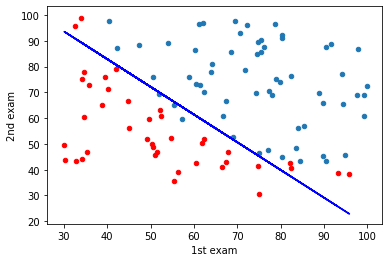

Кол-во итераций: 134116


In [9]:
theta, logs = fit(x_train, y_train)

def x2_func(x1, theta):
    return -(theta[0] + theta[1] * x1) / theta[2]

df_accepted = df[df['accepted'] == 1]
df_not_accepted = df[df['accepted'] == 0]
fig, ax = plt.subplots()
ax.scatter(df_accepted['first_exam'], df_accepted['second_exam'], marker='o', label='Accepted', s=20)
ax.scatter(df_not_accepted['first_exam'], df_not_accepted['second_exam'], marker='o', c='r', label='Not accepted', s=20)
ax.plot(df_not_accepted['first_exam'],
        [x2_func(i, theta) for i in df_not_accepted['first_exam']],
        c='b', label='boundary')
ax.set_xlabel('1st exam')
ax.set_ylabel('2nd exam')
plt.show()
print(f'Кол-во итераций: {len(logs)}')

## 7. Загрузите данные ex2data2.txt из текстового файла.


In [10]:
df = pd.read_csv('data/ex2data2.txt', header=None, names=['first_test', 'second_test', 'passed'])
x_train, y_train = df.filter(['first_test', 'second_test']), df['passed']
df

,first_test,second_test,passed
0,0.051267,0.699560,1
1,-0.092742,0.684940,1
2,-0.213710,0.692250,1
3,-0.375000,0.502190,1
4,-0.513250,0.465640,1
...,...,...,...
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0


## 8. Постройте график, где по осям откладываются результаты тестов, а точки обозначаются двумя разными маркерами в зависимости от того, прошло ли изделие контроль или нет.

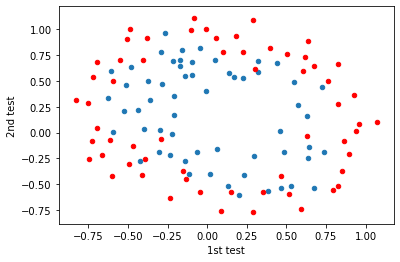

In [11]:
df_accepted = df[df['passed'] == 1]
df_not_accepted = df[df['passed'] == 0]
fig, ax = plt.subplots()
ax.scatter(df_accepted['first_test'], df_accepted['second_test'], marker='o', label='Passed', s=20)
ax.scatter(df_not_accepted['first_test'], df_not_accepted['second_test'], marker='o', c='r', label='Not passed', s=20)
ax.set_xlabel('1st test')
ax.set_ylabel('2nd test')
plt.show()

## 9. Постройте все возможные комбинации признаков x1 (результат первого теста) и x2 (результат второго теста), в которых степень полинома не превышает 6, т.е. 1, x1, x2, x12, x1x2, x22, …, x1x25, x26 (всего 28 комбинаций).

In [12]:
def build_feature_for_pair(x1, x2, degree):
    res = []
    for i in range(degree + 1):
            for j in range(i, degree + 1):
                res.append(x1**(j - i) * x2**i)
    return res

def build_features(x1, x2, degree):
    return [build_feature_for_pair(x1[idx], x2[idx], degree) for idx in range(len(x1))]

In [13]:
extended_x_train = build_features(x_train['first_test'], x_train['second_test'], 6)
extended_x_train = pd.DataFrame(extended_x_train)

## 10. Реализуйте L2-регуляризацию для логистической регрессии и обучите ее на расширенном наборе признаков методом градиентного спуска.

In [14]:
# https://medium.com/datadriveninvestor/l1-l2-regularization-7f1b4fe948f2

def cost_func_vectorized_reg_l2(x, y, theta, penalty_term=0.1):
    cost = cost_func_vectorized(x, y, theta)
    theta_sliced = theta[1:]
    penalty_cost = (penalty_term / 2 / x.shape[0]) * np.dot(theta_sliced.T, theta_sliced)
    return cost + penalty_cost

def cost_func_deriative_reg_l2(x, y, theta, penalty_term=0.1):
    err = h(x, theta) - y
    grad = np.dot(x.T[:1], err)
    grad_with_reg = np.dot(x.T[1:], err) + penalty_term * theta[1:]
    grad = np.insert(grad_with_reg, 0, grad)
    grad /= x.shape[0]
    return grad

In [15]:
theta, logs = fit(extended_x_train, y_train, minimization_func=gradient_descent_vectorized,
               regularized=True, cost_func=cost_func_vectorized_reg_l2, cost_func_der=cost_func_deriative_reg_l2)
theta, logs[-1][1]

(array([ 2.47044991,  1.65382342, -3.94598303,  0.60846478, -3.03470089,
        -0.41870361, -2.27733632,  2.62767817, -2.69166142, -1.03075147,
        -0.00732896, -0.52230883,  0.15169121, -3.36472317, -0.83139245,
        -1.48613724,  0.07937035, -0.68211161, -0.22066692, -0.9332698 ,
        -0.78201023,  0.10385866, -2.50869643, -0.91520568, -0.83383276,
        -0.52838867, -0.60401967, -1.6019049 ]), 0.39766269795075404)

## 11. Реализуйте другие методы оптимизации.

In [16]:
theta1, logs1 = fit(extended_x_train, y_train, minimization_func=nelder_mead_algo,
                  regularized=True, cost_func=cost_func_vectorized_reg_l2)
theta2, logs2 = fit(extended_x_train, y_train, minimization_func=bfgs_algo,
                  regularized=True, cost_func=cost_func_vectorized_reg_l2, cost_func_der=cost_func_deriative_reg_l2)
theta1, theta2

Optimization terminated successfully.
         Current function value: 0.465545
         Iterations: 27753
         Function evaluations: 33382
Optimization terminated successfully.
         Current function value: 0.394594
         Iterations: 136
         Function evaluations: 137
         Gradient evaluations: 137


(array([ 2.3127117 ,  0.60394044, -5.58035455,  2.431011  , -1.79607751,
        -0.59007333, -0.52179195,  2.27876777, -1.82247495, -2.21304662,
         1.52207541,  2.68708933, -1.28528444, -2.74410273, -2.97284783,
         0.40094661,  2.10129466,  3.49785269, -1.78093335, -1.60371914,
         1.36959552,  0.60179941, -1.66845555,  2.15891957, -1.36062064,
        -0.08072131,  2.86706813,  0.04203006]),
 array([ 2.75388397,  1.80721584, -4.21449797,  0.74553063, -3.26575471,
        -0.62160039, -2.63126755,  2.95666289, -3.3795092 , -1.07820308,
         0.52791635, -0.47032487,  0.44537568, -4.22534326, -0.47234091,
        -1.76305288,  0.62375524, -0.73621705, -0.49912867, -1.20788555,
        -1.13701413,  0.42673693, -2.77794795, -1.21215545, -1.14910458,
        -0.09178338, -0.95793641, -1.14890432]))

## 12. Реализуйте функцию предсказания вероятности прохождения контроля изделием в зависимости от результатов тестов.

Функция predict реализована выше. (Задание 5)

## 13. Постройте разделяющую кривую, полученную в результате обучения модели. Совместите прямую с графиком из пункта 7.

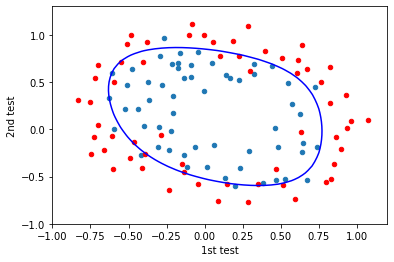

In [17]:
def draw_boder(theta):
    u = np.linspace(-1, 1.2, 50)
    v = np.linspace(-1, 1.3, 50)
    z = np.zeros(shape=(len(u), len(v)))
    for i in range(len(u)):
        for j in range(len(v)):
            features_list = build_feature_for_pair(np.array(u[i]), np.array(v[j]), degree=6)
            np.mat(features_list).dot(theta)
            z[i, j] = np.mat(features_list).dot(theta)

    z = z.T

    fig, ax = plt.subplots()
    ax.contour(u, v, z, levels=0, colors='b')

    df_accepted = df[df['passed'] == 1]
    df_not_accepted = df[df['passed'] == 0]
    ax.scatter(df_accepted['first_test'], df_accepted['second_test'], marker='o', label='Passed', s=20)
    ax.scatter(df_not_accepted['first_test'], df_not_accepted['second_test'], marker='o', c='r', label='Not passed', s=20)
    ax.set_xlabel('1st test')
    ax.set_ylabel('2nd test')
    plt.show()

draw_boder(theta)

## 14. Попробуйте различные значения параметра регуляризации λ. Как выбор данного значения влияет на вид разделяющей кривой? Ответ дайте в виде графиков.


In [18]:
theta1, _ = fit(extended_x_train, y_train, minimization_func=gradient_descent_vectorized,
               regularized=True, cost_func=cost_func_vectorized_reg_l2, cost_func_der=cost_func_deriative_reg_l2,
               penalty_term=0.5)

theta2, _ = fit(extended_x_train, y_train, minimization_func=gradient_descent_vectorized,
               regularized=True, cost_func=cost_func_vectorized_reg_l2, cost_func_der=cost_func_deriative_reg_l2,
               penalty_term=1)

theta3, _ = fit(extended_x_train, y_train, minimization_func=gradient_descent_vectorized,
               regularized=True, cost_func=cost_func_vectorized_reg_l2, cost_func_der=cost_func_deriative_reg_l2,
               penalty_term=0)

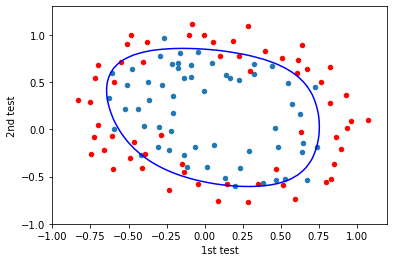

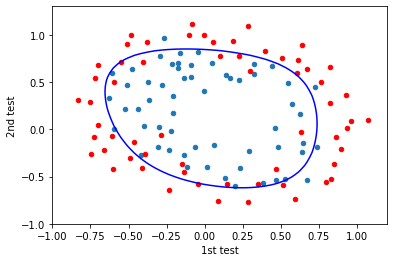

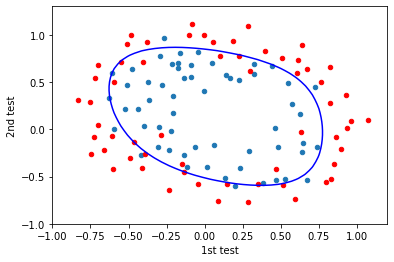

In [19]:
draw_boder(theta1)
draw_boder(theta2)
draw_boder(theta3)

## 15. Загрузите данные ex2data3.mat из файла.

In [20]:
from scipy.io import loadmat

mat = loadmat('data/ex2data3.mat')
x_train, y_train = mat['X'], mat['y']
y_train = y_train.reshape(y_train.shape[0])
y_train = np.where(y_train != 10, y_train, 0)

## 15. Визуализируйте несколько случайных изображений из набора данных. Визуализация должна содержать каждую цифру как минимум один раз.

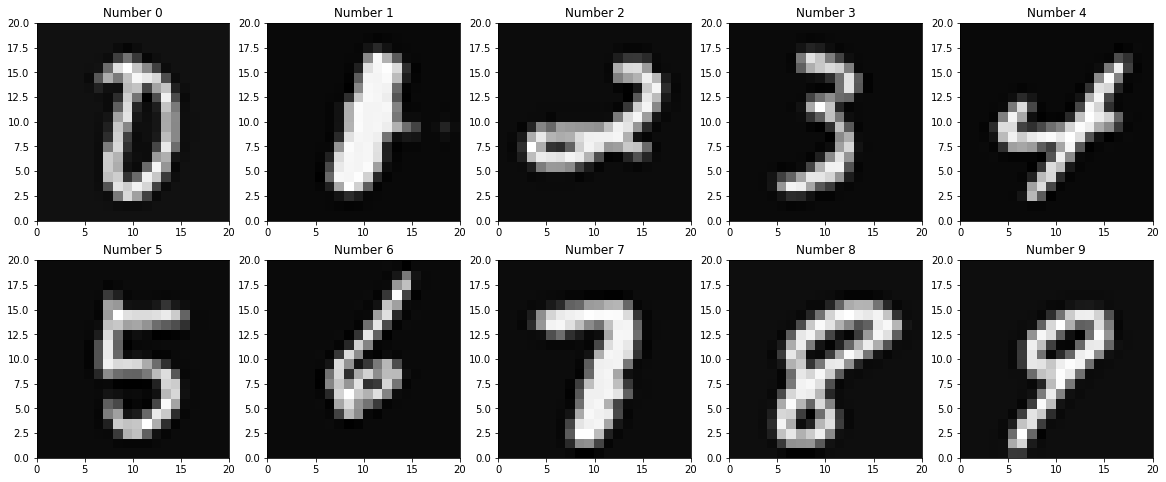

In [21]:
def vector_to_matrix(x):
    len_vec = len(x)
    step = int(np.sqrt(len_vec))
    matrix = [x[left:left+step] for left in range(0, len_vec, step)]
    np_matrix = np.array(matrix).T
    reversed_matrix = np.flip(np_matrix, axis=0)
    return reversed_matrix

nums = list(range(150, 5000, 500))
pictures = [vector_to_matrix(x_train[i]) for i in nums]

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()):
    ax.pcolor(pictures[i], cmap=cm.gray)
    res = y_train[nums[i]]
    if res == 10:
        res = 0
    ax.set_title(f'Number {res}')

plt.show()

## 16. Реализуйте бинарный классификатор с помощью логистической регрессии с использованием векторизации (функции потерь и градиентного спуска).
Было выполнено выше.

## 17. Добавьте L2-регуляризацию к модели.
Было выполнено выше.

## 18. Реализуйте многоклассовую классификацию по методу “один против всех”.

In [100]:
import time
class MultiClassifier:
    def __init__(self):
        self.thetas = []

    def fit(self, x_train, y_train):
        for i in range(10):
            y_i_train = (y_train == i).astype(int)
            start_time = time.time()
            theta, logs = fit(x_train, y_i_train, minimization_func=gradient_descent_vectorized, regularized=True)
            print(f'trained {i}', time.time() - start_time)
            print(f'loss func {logs[-1][1]}')
            self.thetas.append(theta)

    def predict(self, x):
        predictions = []
        for theta in self.thetas:
            predictions.append(h(x, theta))
        
        return np.argmax(np.array(predictions), axis=0)

In [101]:

classifier = MultiClassifier()
classifier.fit(x_train, y_train)

trained 0 71.1786150932312
loss func 0.006911037961354453
trained 1 60.524169921875
loss func 0.008106438164563672
trained 2 59.84246015548706
loss func 0.048633318001316685
trained 3 60.410317182540894
loss func 0.06327870032957407
trained 4 60.49494504928589
loss func 0.026817677787345492
trained 5 67.51234197616577
loss func 0.047069799972334285
trained 6 60.69632291793823
loss func 0.013305677997684244
trained 7 60.60066604614258
loss func 0.0253995614965456
trained 8 63.60757088661194
loss func 0.11255046838173148
trained 9 74.15731811523438
loss func 0.07767526600663748


## 19. Реализуйте функцию предсказания класса по изображению с использованием обученных классификаторов.
Реализована в классе MultiClassifier.

## 20. Процент правильных классификаций на обучающей выборке должен составлять около 95%.

In [104]:
# a=1 max_iter_count=30000
def accuracy(model, x, y):
    results_diffs = model.predict(x) - y
    incorrect_results = np.count_nonzero(results_diffs)
    return 1 - (incorrect_results / len(results_diffs))

In [105]:
acc = accuracy(classifier, x_train, y_train)
print(f"Accuracy: {acc}")

Accuracy: 0.9586
